<a href="https://colab.research.google.com/github/esleire/Box-Office-Cinema/blob/master/BoxOffice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
train_ = pd.read_csv('drive/MyDrive/ML2/train.csv')
test_ = pd.read_csv('drive/MyDrive/ML2/test.csv')
sampleSubmission = pd.read_csv('drive/MyDrive/ML2/sample_submission.csv')

train = train_.copy(); 
test = test_.copy(); 
test_id = test['id'].copy()

In [ ]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",08-06-04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10-10-14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",03-09-12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",02-05-09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [ ]:
test.head() 

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
0,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,/tnftmLMemPLduW6MRyZE0ZUD19z.jpg,NaN,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de..."
1,3002,NaN,88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,/9MgBNBqlH1sG4yG2u4XkwI5CoJa.jpg,"[{'name': 'Woolner Brothers Pictures Inc.', 'i...","[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de..."
2,3003,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,/ed6nD7h9sbojSWY2qrnDcSvDFko.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",5/23/97,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de..."
3,3004,NaN,6800000,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.sonyclassics.com/incendies/,tt1255953,fr,Incendies,A mother's last wishes send twins Jeanne and S...,8.596012,/sEUG3qjxwHjxkzuO7plrRHhOZUH.jpg,"[{'name': 'TS Productions', 'id': 313}, {'name...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",09-04-10,130.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,The search began at the opening of their mothe...,Incendies,"[{'id': 378, 'name': 'prison'}, {'id': 539, 'n...","[{'cast_id': 6, 'character': 'Nawal', 'credit_...","[{'credit_id': '56478092c3a36826140043af', 'de..."
4,3005,NaN,2000000,"[{'id': 36, 'name': 'History'}, {'id': 99, 'na...",NaN,tt0418753,en,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget...",3.217680,/n4WC3zbelz6SG7rhkWbf8m9pMHB.jpg,NaN,"[{'iso_3166_1': 'US', 'name': 'United States o...",02-11-05,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was filmed in 6 days for 25 thousand dollar...,Inside Deep Throat,"[{'id': 279, 'name': 'usa'}, {'id': 1228, 'nam...","[{'cast_id': 1, 'character': 'Narrator (voice)...","[{'credit_id': '52fe44ce9251416c75041967', 'de..."


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4398 non-null   int64  
 1   belongs_to_collection  877 non-null    object 
 2   budget                 4398 non-null   int64  
 3   genres                 4382 non-null   object 
 4   homepage               1420 non-null   object 
 5   imdb_id                4398 non-null   object 
 6   original_language      4398 non-null   object 
 7   original_title         4398 non-null   object 
 8   overview               4384 non-null   object 
 9   popularity             4398 non-null   float64
 10  poster_path            4397 non-null   object 
 11  production_companies   4140 non-null   object 
 12  production_countries   4296 non-null   object 
 13  release_date           4397 non-null   object 
 14  runtime                4394 non-null   float64
 15  spok

In [ ]:
# !pip install pycaret

In [ ]:
#from pycaret.classification import *
#grid = pycaret.setup(data=train, target=df.columns[-1], html=False, silent=True, verbose=False)

# Data Cleaning



First we plot the popularity of the movies against revenue. As we see it, it doesn't seem to be very relevant, but we include it in our set for now. 

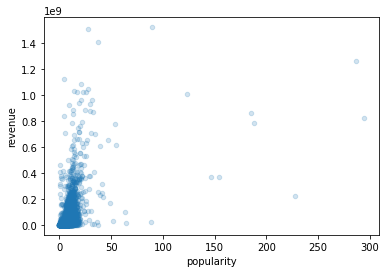

In [ ]:
train.plot(kind="scatter", x="popularity", y="revenue", alpha=0.2)

We plot the budget against revenue to check if this is relevant, this seems highly relevant as bigger budgets provide bigger revenue. 

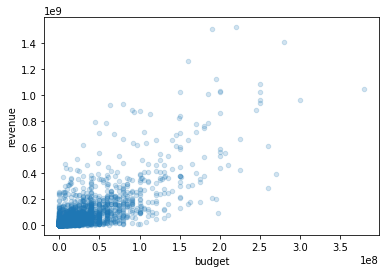

In [ ]:
train.plot(kind="scatter", x="budget", y="revenue", alpha=0.2)

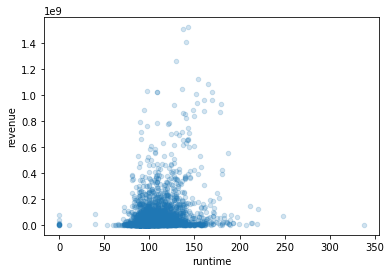

In [ ]:
train.plot(kind="scatter", x="runtime", y="revenue", alpha=0.2)

Make a new attribute that tells whether a movie's original language is English or not. Then plot that new attribute against revenue and we can clearly see that whether a movie is in English or not is a deciding factor on its success at the box office.

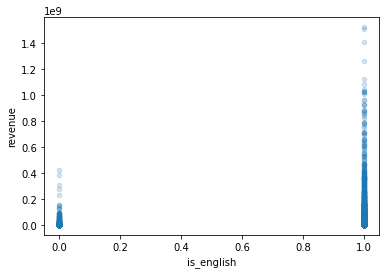

In [ ]:
train["is_english"] = train["original_language"].apply(lambda x: 1 if x == "en" else 0)
test["is_english"] = test["original_language"].apply(lambda x: 1 if x == "en" else 0)

train.plot(kind="scatter", x="is_english", y="revenue", alpha=0.2)

In [ ]:
import numpy as np
train["has_collection"] = train["belongs_to_collection"].apply(lambda x: 0 if x is np.nan else 1)
test["has_collection"] = test["belongs_to_collection"].apply(lambda x: 0 if x is np.nan else 1)

train["has_homepage"] = train["homepage"].apply(lambda x: 0 if x is np.nan else 1)
test["has_homepage"] = test["homepage"].apply(lambda x: 0 if x is np.nan else 1)

train["crew_count"] = train["crew"].apply(lambda x: 0 if x is np.nan else x.count('{'))
test["crew_count"] = test["crew"].apply(lambda x: 0 if x is np.nan else x.count('{'))

train["cast_count"] = train["cast"].apply(lambda x: 0 if x is np.nan else x.count('{'))
test["cast_count"] = test["cast"].apply(lambda x: 0 if x is np.nan else x.count('{'))

train["cast_count"].head(3)

0    24
1    20
2    51
Name: cast_count, dtype: int64

## Correlation Matrix
Since we have converted some objects to floats we want to test the influcence of the new attributes on the revenue. 

In [ ]:
corr_matrix = train.corr()
corr_matrix["revenue"].sort_values(ascending=False)

revenue           1.000000
budget            0.752965
popularity        0.461460
crew_count        0.372110
has_collection    0.339425
cast_count        0.335737
has_homepage      0.263179
runtime           0.216380
is_english        0.142130
id                0.000610
Name: revenue, dtype: float64

We analyse the matrix and look for opportunities to improve the scores. We decided to combine the attributes crew_count and cast_count.

In [ ]:
#Adding the values of crew_count and cast_count in a new attribute
sum_list_train = []
for (item1, item2) in zip(train["crew_count"], train["cast_count"]):

  sum_list_train.append(item1+item2)


In [ ]:
sum_list_test = []
for (item1, item2) in zip(test["crew_count"], test["cast_count"]):

  sum_list_test.append(item1+item2)


In [ ]:
train["crewcast_total"] = sum_list_train;
test["crewcast_total"] = sum_list_test

In [ ]:
corr_matrix = train.corr()
corr_matrix["revenue"].sort_values(ascending=False)

revenue           1.000000
budget            0.752965
popularity        0.461460
crewcast_total    0.425115
crew_count        0.372110
has_collection    0.339425
cast_count        0.335737
has_homepage      0.263179
runtime           0.216380
is_english        0.142130
id                0.000610
Name: revenue, dtype: float64

We remove all the objects from the set before passing it into the transformation pipeline since our models only works with numbers.

In [ ]:
train_labels = train["revenue"].copy()
train = train.drop("revenue", axis=1)

#train = train.drop("cast_count", axis=1)
#train = train.drop("crew_count", axis=1)
train = train.drop("has_homepage", axis=1)

test = test.drop("has_homepage", axis=1)
#test = test.drop("cast_count", axis=1)
#test = test.drop("crew_count", axis=1)

train = train.drop("crewcast_total", axis=1)

df = pd.DataFrame(train)
df = df.select_dtypes(exclude=['object'])
train_num = df.drop('id', axis=1)


df_test = pd.DataFrame(test)
df_test = df_test.select_dtypes(exclude=['object'])
test_num = df_test.drop('id', axis=1)

## Transformation Pipeline


In [ ]:
train_num_attribs = list(train_num)
test_num_attribs = list(test_num)

In [ ]:
train_num.head(5);

In [ ]:
test_num.head(5);

In [ ]:
from sklearn.impute import SimpleImputer 
imputer = SimpleImputer(strategy="median")
imputer.fit(train_num);

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

In [ ]:
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder
num_attribs = list(train_num)
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
    ])
train_num_tr = full_pipeline.fit_transform(train_num)


test_num_tr = full_pipeline.transform(test_num)

/usr/local/lib/python3.7/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


## Testing different training alogrithms

In [ ]:
X = train_num_tr
y = train_labels


In [ ]:
from sklearn.linear_model import LinearRegression 
lin_reg = LinearRegression()
lin_reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(random_state=69)
forest_reg.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=69, verbose=0, warm_start=False)

In [ ]:
from sklearn.metrics import mean_squared_error
lin_predictions = lin_reg.predict(X)
lin_mse = mean_squared_error(y, lin_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

82120347.7870515

In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(random_state=69)
forest_reg.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=69, verbose=0, warm_start=False)

In [ ]:
forest_reg_predictions = forest_reg.predict(X)
forest_mse = mean_squared_error(y, forest_reg_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

30025561.721004225

## Fine tuning


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=7),
        'n_jobs': [-1]
    }

forest_reg = RandomForestRegressor(random_state=69)

rnd_search = RandomizedSearchCV(
                forest_reg, 
                param_distributions=param_distribs,
                n_iter=10, 
                cv=5, 
                scoring='neg_mean_squared_error', 
                random_state=69
            )

rnd_search.fit(X, y)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [ ]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

78199383.43982348 {'max_features': 4, 'n_estimators': 108, 'n_jobs': -1}
77686143.39231473 {'max_features': 3, 'n_estimators': 184, 'n_jobs': -1}
78400570.68203758 {'max_features': 5, 'n_estimators': 50, 'n_jobs': -1}
78224632.92540301 {'max_features': 2, 'n_estimators': 185, 'n_jobs': -1}
79227112.7879313 {'max_features': 2, 'n_estimators': 39, 'n_jobs': -1}
79075444.80422239 {'max_features': 1, 'n_estimators': 89, 'n_jobs': -1}
78195400.75567576 {'max_features': 5, 'n_estimators': 166, 'n_jobs': -1}
77733179.94725773 {'max_features': 3, 'n_estimators': 76, 'n_jobs': -1}
88696772.07183877 {'max_features': 6, 'n_estimators': 4, 'n_jobs': -1}
79282239.86615768 {'max_features': 1, 'n_estimators': 168, 'n_jobs': -1}


In [ ]:
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_importances

array([0.45166635, 0.23189044, 0.09088436, 0.00289836, 0.06112424,
       0.07895907, 0.08257717])

In [ ]:
sorted(zip(feature_importances, num_attribs), reverse=True)

[(0.45166634623324964, 'budget'),
 (0.2318904360840868, 'popularity'),
 (0.09088436499588295, 'runtime'),
 (0.08257717242378496, 'cast_count'),
 (0.07895907385805255, 'crew_count'),
 (0.06112424426151302, 'has_collection'),
 (0.0028983621434300576, 'is_english')]

In [ ]:
rnd_search.best_params_

{'max_features': 3, 'n_estimators': 184, 'n_jobs': -1}

## Final model

In [ ]:
final_model = rnd_search.best_estimator_
final_predictions_S =  final_model.predict(test_num_tr)

print(final_predictions_S)

[1.36260404e+07 3.77255023e+06 1.26293700e+07 ... 5.05925089e+07
 1.11042700e+08 2.43551925e+07]


In [ ]:
len(final_predictions_S)

4398

In [ ]:
submission = pd.DataFrame({
    'id': test_id,
    'revenue': final_predictions_S
})

In [ ]:
submission.head()

,id,revenue
0,3001,1.362604e+07
1,3002,3.772550e+06
2,3003,1.262937e+07
3,3004,5.071213e+07
4,3005,4.678645e+06


##Final Predictions
For our first submission, we started by looking at which of the attributes were most relevant for a movie's total revenue. Since some of the attributes were objects, we had to turn them into numerical attributes, after which we made a corrolation matrix to see which attributes had the most impact on the revenue. Then we got rid of the attributes we deemed irrelevant and began trying a few models on it. After finding the model we thought gave the best score, we ran it on the test set and submitted it on Kaggle, which led to a score of 2.64464.

For our second submission, we tried dropping has_homepage from the training set and that got us down to a score of 2.63913.


In [ ]:
submission.to_csv('drive/MyDrive/ML2/submission.csv', index=False)

## Export Model 

In [ ]:
from joblib import dump
dump(final_model, 'drive/MyDrive/ML2/TMDB_fr.joblib', compress=6)

['drive/MyDrive/ML2/TMDB_fr.joblib']